In [1]:
import numpy as np
from collections import OrderedDict

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#def softmax(x):
#        c = np.max(x)
#        exp_x = np.exp(x - c)
#        sum_exp_x = np.sum(exp_x)
#        y = exp_x / sum_exp_x
#        
#        return y
 
def softmax(x):
    if x.ndim == 2:
        c = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    else:
        c = np.max(x)
        exp_x = np.exp(x - c)
        return exp_x / np.sum(exp_x)
       
def CEE(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

def gradient(f, x):
    h = 0.0001

    shape = x.shape
    x_flatten = x.reshape(-1)
    size = len(x_flatten)

    grad = np.zeros_like(x_flatten)

    for i in range(size):
        x_val = x_flatten[i]

        x_flatten[i] = x_val + h
        fxh1 = f(x_flatten.reshape(shape))

        x_flatten[i] = x_val - h
        fxh2 = f(x_flatten.reshape(shape))

        grad[i] = (fxh1 - fxh2) / (2*h)

        x_flatten[i] = x_val
        
    return grad.reshape(shape)

class ReLU:
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        self.x = x
        return (x > 0)*x
    
    def backward(self, dz):
        return dz*(self.x > 0).astype(int)
    
class Sigmoid:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x):
        self.x = x
        self.y = 1 / (1 + np.exp(-self.x))
        return self.y
    
    def backward(self, dz):
        return dz * self.y *(1 - self.y)
    
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.X = None 
        
    def forward(self, X):
        self.X = X        
        return np.dot(X, self.W) + self.b
    
    def backward(self, dz):
        grads = {}
        grads["W"] = np.dot(self.X.T, dz)
        grads["X"] = np.dot(dz, self.W.T)
        grads["b"] = np.sum(dz, axis=0)
        
        return grads

class Softmax_with_Loss:
    def __init__(self):
        self.y = None
        self.t = None
        
    def forward(self, X, t):
        self.y = softmax(X)
        self.t = t
        loss = CEE(self.y, self.t)
        
        return loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        return (self.y - self.t) / batch_size
    
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        # layer 1
        self.params["W1"] = 0.01 * np.random.randn(input_size,hidden_size)
        self.params["B1"] = 0.01 * np.random.randn(hidden_size)
        #layer 2
        self.params["W2"] = 0.01 * np.random.randn(hidden_size,output_size)
        self.params["B2"] = 0.01 * np.random.randn(output_size)
        
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X):
        h = self.layer["Affine1"].forward(X)
        h = self.layer["ReLU1"].forward(h)
        y = self.layer["Affine2"].forward(h)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        Y = self.predict(x)
        predict_label = np.argmax(Y, axis=1)
        target_label = np.argmax(t, axis=1)
        return np.sum(predict_label == target_label) / len(predict_label)
    
    def numerical_gradient(self, x, t):
        grads = {}

        for key in self.params:
            original_param = self.params[key]

            def loss_func(param):
                self.params[key][...] = param
                y = self.predict(x)
                return self.last_layer.forward(y, t)

            h = 1e-4
            shape = original_param.shape
            param_flat = original_param.reshape(-1)
            grad = np.zeros_like(param_flat)

            for i in range(len(param_flat)):
                tmp_val = param_flat[i]

                param_flat[i] = tmp_val + h
                fxh1 = loss_func(param_flat.reshape(shape))

                param_flat[i] = tmp_val - h
                fxh2 = loss_func(param_flat.reshape(shape))

                grad[i] = (fxh1 - fxh2) / (2 * h)

                param_flat[i] = tmp_val

            grads[key] = grad.reshape(shape)
            #self.params[key] = original_param
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t)
        grads = {}
        
        dout = self.last_layer.backward()
        temp_grads = self.layer["Affine2"].backward(dout)
        grads["W2"] = temp_grads["W"]
        grads["B2"] = temp_grads["b"]
        dout = temp_grads["X"]
        
        dout = self.layer["ReLU1"].backward(dout)
        
        temp_grads = self.layer["Affine1"].backward(dout)
        grads["W1"] = temp_grads["W"]
        grads["B1"] = temp_grads["b"]
        
        return grads

In [2]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] = params[key] - self.lr*grads[key]

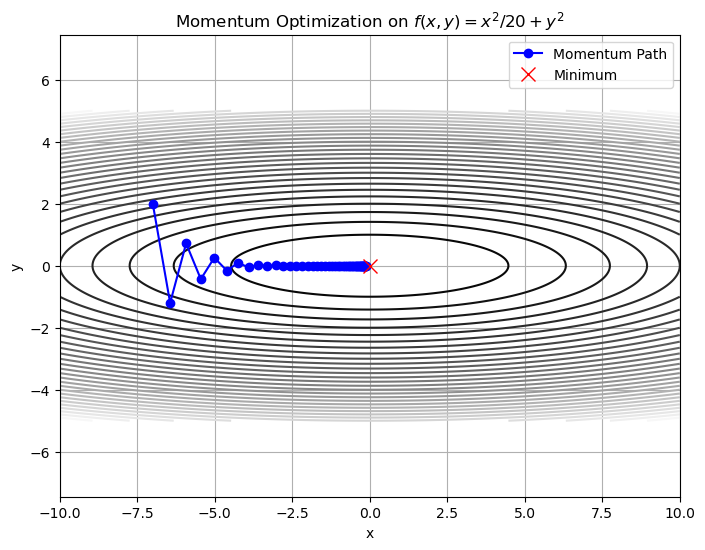

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의 및 수치 미분
def function_2(params):
    x, y = params['x']
    return (x ** 2) / 20 + y ** 2

def numerical_gradient(f, params):
    h = 1e-4
    grad = {}
    x = params['x']
    grad['x'] = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(params)

        x[idx] = tmp_val - h
        fxh2 = f(params)

        grad['x'][idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

# 초기화
init_pos = np.array([-7.0, 2.0])
params = {'x': init_pos.copy()}
optimizer = SGD(lr=0.8)

x_history = []

# 최적화 루프
for _ in range(50):
    x_history.append(params['x'].copy())
    grads = numerical_gradient(function_2, params)
    optimizer.update(params, grads)

x_history = np.array(x_history)

# 등고선 그리기
x = np.linspace(-10, 10, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X ** 2) / 20 + Y ** 2

plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=30, cmap='gray')
plt.plot(x_history[:, 0], x_history[:, 1], 'o-', color='blue', label='Momentum Path')
plt.plot(0, 0, 'rx', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Optimization on $f(x, y) = x^2/20 + y^2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [4]:
class Momentum:
    def __init__(self, lr, momentum):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v == None:
            self.v = {}
            for key, param in params.items():
                self.v[key] = np.zeros_like(param)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] = params[key] + self.v[key]

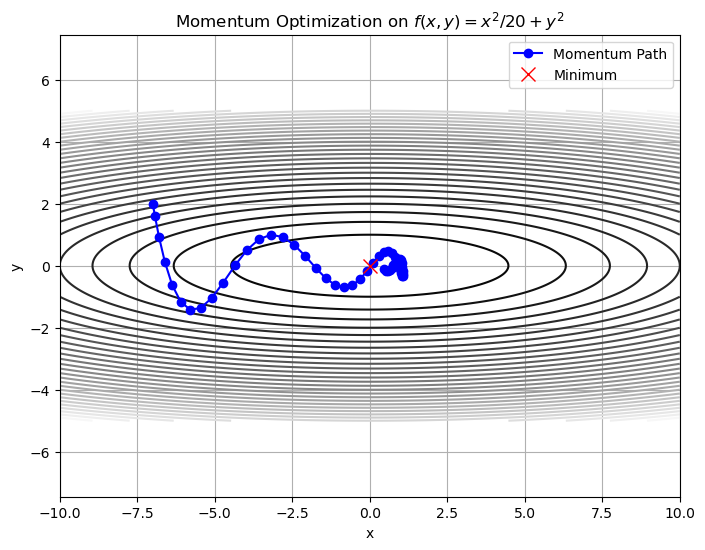

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의 및 수치 미분
def function_2(params):
    x, y = params['x']
    return (x ** 2) / 20 + y ** 2

def numerical_gradient(f, params):
    h = 1e-4
    grad = {}
    x = params['x']
    grad['x'] = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(params)

        x[idx] = tmp_val - h
        fxh2 = f(params)

        grad['x'][idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

# 초기화
init_pos = np.array([-7.0, 2.0])
params = {'x': init_pos.copy()}
optimizer = Momentum(lr=0.1, momentum=0.9)

x_history = []

# 최적화 루프
for _ in range(50):
    x_history.append(params['x'].copy())
    grads = numerical_gradient(function_2, params)
    optimizer.update(params, grads)

x_history = np.array(x_history)

# 등고선 그리기
x = np.linspace(-10, 10, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X ** 2) / 20 + Y ** 2

plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=30, cmap='gray')
plt.plot(x_history[:, 0], x_history[:, 1], 'o-', color='blue', label='Momentum Path')
plt.plot(0, 0, 'rx', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Optimization on $f(x, y) = x^2/20 + y^2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [ ]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h == None:
            self.h = {}
            for key, param in params.items():
                self.h[key] = np.zeros_like(param)
        
        for key in params.keys():
            self.h[key] = self.h[key] + grads[key]*grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

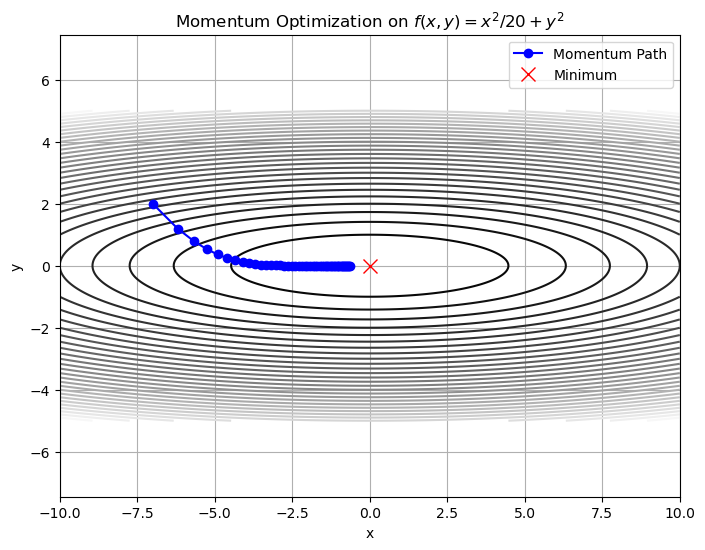

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의 및 수치 미분
def function_2(params):
    x, y = params['x']
    return (x ** 2) / 20 + y ** 2

def numerical_gradient(f, params):
    h = 1e-4
    grad = {}
    x = params['x']
    grad['x'] = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(params)

        x[idx] = tmp_val - h
        fxh2 = f(params)

        grad['x'][idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

# 초기화
init_pos = np.array([-7.0, 2.0])
params = {'x': init_pos.copy()}
optimizer = AdaGrad(lr=0.8)

x_history = []

# 최적화 루프
for _ in range(50):
    x_history.append(params['x'].copy())
    grads = numerical_gradient(function_2, params)
    optimizer.update(params, grads)

x_history = np.array(x_history)

# 등고선 그리기
x = np.linspace(-10, 10, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X ** 2) / 20 + Y ** 2

plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=30, cmap='gray')
plt.plot(x_history[:, 0], x_history[:, 1], 'o-', color='blue', label='Momentum Path')
plt.plot(0, 0, 'rx', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Optimization on $f(x, y) = x^2/20 + y^2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [8]:
# Adam도 해보기